In [14]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.opimize import nnls
%matplotlib ipympl

# Define the aperture function (rectangular)
def rectangular_aperture(x, width):
    return np.where(np.abs(x) <= width / 2, 1, 0)

def tophat(x, R, m):
    return np.exp(-np.sqrt((x**2)/(R**2))**m)

def w_z(w0, z, zR):
    return w0 * np.sqrt(1 + (z / zR) ** 2)

def R(z, z_r):
    return z * (1 + (z_r / z) ** 2)

def Q_inv(z, z_r, w0, wl):
    return 1 / R(z, z_r) + 1j * wl / (np.pi * w_z(w0, z, z_r) ** 2)
    
def zR(w0, wavelength):
    return (np.pi * w0 ** 2) / wavelength

def gaussian_beam(E0, x, x0, y, y0, w0, zR):
    return E0 * (w0 / w_z(w0, 0, zR)) * np.exp(- ((x - x0) + (y - y0) / w_z(w0, 0, zR)) ** 2)

def prop_ray(ray, dz):
    return ray * dz

def calculate_direction_cosines(x0, y0, z0, x1, y1, z1):
    # Calculate the principal ray vector from ray coordinate on object to centre of lens
    vx = x1 - x0
    vy = y1 - y0
    vz = z1 - z0
    v_mag = np.sqrt(vx**2 + vy**2 + vz**2)
    
    # And it's direction cosines
    M = vy / v_mag 
    L = vx / v_mag
    N = vz / v_mag
    
    return L, M, N

# Function to propagate a distance z, and obtain the new optical path length. 
def propagate(x, y, z, L, M, N, z_prop, opl):
    dx = (L / N) * z_prop
    dy = (M / N) * z_prop
    dz = (N / N) * z_prop
    x1 = x + dx
    y1 = y + dy
    z1 = z + dz
    
    opl = opl + np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
    
    return x1, y1, z1, opl

def convert_slope_to_direction_cosines(dx, dy):
    l = dx/ np.sqrt(1 + dx ** 2)
    n = 1 / np.sqrt(1 + dx** 2)
    return l, n

def propagate_rays(R, z):
    n = 1 / np.sqrt(1 + R[:, 1] ** 2)
    d = z / n
    ABCD = np.array([[1, d],
                     [0, 1]])
    
    return R @ ABCD

def create_rayset(x, l, y, m, dx, dl, dy, dm, n_rays):
    # Initialize the rayset matrix
    rayset = np.zeros((5, 4, n_rays))
    
    # Populate the rayset with the given variations
    rayset[0, :, :] = [x, y, l, m]
    rayset[1, :, :] = [x + dx, y, l, m]
    rayset[2, :, :] = [x, y + dy, l, m]
    rayset[3, :, :] = [x, y, l + dl, m]
    rayset[4, :, :] = [x, y, l, m + dm]

    return rayset

def differential_matrix(rayset, dPx, dPy, dHx, dHy):
    
    x_cen_T = rayset[0, 0, :]
    x_px_T = rayset[1, 0, :]
    x_py_T = rayset[2, 0, :]
    x_pl_T = rayset[3, 0, :]
    x_pm_T = rayset[4, 0, :]

    y_cen_T = rayset[0, 1, :]
    y_px_T = rayset[1, 1, :]
    y_py_T = rayset[2, 1, :]
    y_pl_T = rayset[3, 1, :]
    y_pm_T = rayset[4, 1, :]

    l_cen_T = rayset[0, 2, :]
    l_px_T = rayset[1, 2, :]
    l_py_T = rayset[2, 2, :]
    l_pl_T = rayset[3, 2, :]
    l_pm_T = rayset[4, 2, :]

    m_cen_T = rayset[0, 3, :]
    m_px_T = rayset[1, 3, :]
    m_py_T = rayset[2, 3, :]
    m_pl_T = rayset[3, 3, :]
    m_pm_T = rayset[4, 3, :]

    # Computing each element of the matrix
    matrix = np.array([
        [(x_px_T - x_cen_T) / dPx, (x_py_T - x_cen_T) / dPy, (x_pl_T - x_cen_T) / dHx, (x_pm_T - x_cen_T) / dHy],
        [(y_px_T - y_cen_T) / dPx, (y_py_T - y_cen_T) / dPy, (y_pl_T - y_cen_T) / dHx, (y_pm_T - y_cen_T) / dHy],
        [(l_px_T - l_cen_T) / dPx, (l_py_T - l_cen_T) / dPy, (l_pl_T - l_cen_T) / dHx, (l_pm_T - l_cen_T) / dHy],
        [(m_px_T - m_cen_T) / dPx, (m_py_T - m_cen_T) / dPy, (m_pl_T - m_cen_T) / dHx, (m_pm_T - m_cen_T) / dHy]
    ])
    
    return matrix

Best to start with a single gaussian, and how to divide that up into a bunch of rays. 

In [20]:
# Setup parameters
raybundle_extent = 0
wavelength = 1.0
wo = 3

div = wavelength / (np.pi * wo)
z_r = (np.pi * wo ** 2) / wavelength

z_ray = 0.0
n_rays = 1

# Setup coordinates
x = np.linspace(-raybundle_extent, raybundle_extent, n_rays)
x, y = np.meshgrid(x, x)

X = x
Y = y

x_ray = x.ravel()
y_ray = y.ravel()

n_rays = len(x_ray)
dx_ray = np.zeros_like(x_ray)
dy_ray = np.zeros_like(y_ray)

z0 = np.zeros((5, n_rays))
opd_in = np.zeros((5, n_rays))

# Propagation distance
z_prop = 10

# Differential quantities for each gaussian
dPx = wo
dPy = wo
dHx = div / np.sqrt(1 + div ** 2 + div ** 2) #direction cosine rather than slope
dHy = div / np.sqrt(1 + div ** 2 + div ** 2)

# Make coordinate bundle of gaussian raysets. 
rayset0 = create_rayset(x_ray, dx_ray, y_ray, dy_ray, dPx, dHx, dPy, dHy, n_rays)

# Propagate raysets a distance in z. 
rayset1 = np.copy(rayset0)
rayset1[:, 0], rayset1[:, 1], z1, opd = propagate(rayset0[:, 0], rayset0[:, 1],  z0, 
                                                  rayset0[:, 2], rayset0[:, 3], 1 / (1 + rayset0[:, 2] ** 2 + rayset0[:, 3] ** 2), 
                                                  z_prop, opd_in)


In [21]:
ABCD = differential_matrix(x_px_T, x_cen_T, x_px_S, x_cen_S,
                           y_py_T, y_cen_T, y_py_S, y_cen_S,
                           l_pl_T, l_cen_T, l_pl_S, l_cen_S,
                           m_pm_T, m_cen_T, m_pm_S, m_cen_S,
                           x_py_T, y_px_T, l_px_T, m_px_T,
                           x_pl_T, y_pl_T, l_py_T, m_py_T,
                           x_pm_T, y_pm_T, l_pm_T, m_pl_T)

ABCD = ABCD.transpose(2, 0, 1)
A = ABCD[:, 0:2, 0:2]
B = ABCD[:, 0:2, 2:4]
C = ABCD[:, 2:4, 0:2]
D = ABCD[:, 2:4, 2:4]

In [ ]:

qinv = 1/(1j*z_r)
Qinv = np.asarray([[qinv,0],[0,qinv]])
Qinv = Qinv[np.newaxis]
Num = (C + np.matmul(D , Qinv))
Den =  np.linalg.inv(A + np.matmul(B, Qinv))
Qpinv = np.matmul(Num,Den)
Amplitude = 1/(np.sqrt(np.linalg.det(A + B @ Qpinv)))

In [48]:
z = z_prop * np.zeros_like(z0)
z = z[:, np.newaxis, :]
zData = z[:, np.newaxis, :]
xData, yData = rayset1[:, np.newaxis, 0], rayset1[:, np.newaxis, 1]

n = (1 + rayset1[:, 2] ** 2 + rayset1[:, 3] ** 2)
nData = n[:, np.newaxis, :]
lData, mData = rayset1[:, np.newaxis, 2], rayset1[:, np.newaxis, 3]
print(zData.shape, xData.shape, yData.shape)
xEnd, yEnd, zEnd = rayset1[:, 0], rayset1[:, 1], zData[:, 0, 0]
lEnd, mEnd, nEnd = rayset1[:, 2], rayset1[:, 3], 1 / (1 + rayset1[:, 2] ** 2 + rayset1[:, 3] ** 2)
print(xEnd.shape, zEnd.shape)

(5, 1, 1, 60) (5, 1, 60) (5, 1, 60)
(5, 60) (5, 60)


In [49]:
from poke.poke_core import Rayfront
from poke.beamlets import transversal_phase, center_transversal_plane, orthogonal_transformation_matrix, distance_to_transversal, propagate_rays_and_transform
nrays = 10
wvl = 1.0
k = 2 * np.pi / wavelength

r_ray = np.moveaxis(np.asarray([xEnd,yEnd,zEnd]),0,-1)
k_ray = np.moveaxis(np.asarray([lEnd,mEnd,nEnd]),0,-1)

dsize = 100
npix = 256
x = np.linspace(-dsize/2,dsize/2,npix)
x,y = np.meshgrid(x,x)
dcoords = np.asarray([x.ravel(),y.ravel(),0*x.ravel()])
dnorm = np.array([[0., 0., 1.]])

O = orthogonal_transformation_matrix(k_ray[0],dnorm)
Delta = distance_to_transversal(dcoords,r_ray,k_ray)
r_ray,k_ray = propagate_rays_and_transform(r_ray,k_ray,Delta,O)
r = center_transversal_plane(dcoords, r_ray, O)
transversal = -1j*k*transversal_phase(Qpinv,r)

field = np.zeros([dcoords.shape[1]],dtype=np.complex128)
field += np.sum(Amplitude*np.exp(transversal),axis=1)
field = field.reshape(npix,npix)


n shape =  (60, 3)
r shape =  (3, 65536)
n @ r shape (5, 60, 65536)


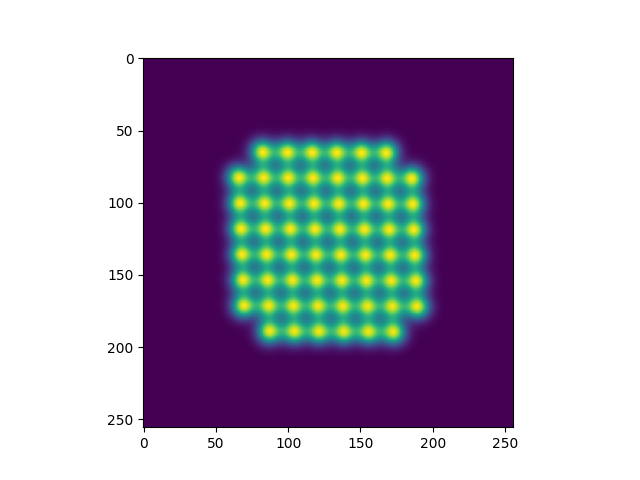

In [50]:
plt.figure()
plt.imshow(np.abs(field))

ValueError: x and y can be no greater than 2D, but have shapes (2, 5, 10) and (2, 5, 10)

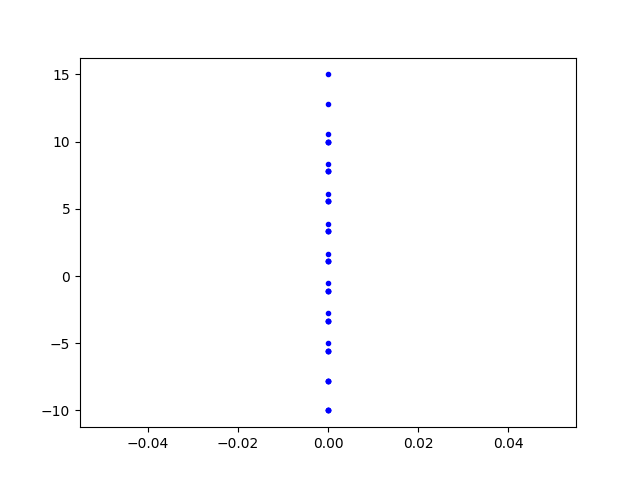

In [25]:
plt.figure()
plt.plot(z_ray, w_z(wo, z_ray, z_r))
plt.plot(z_ray, w_z(-wo, z_ray, z_r))
plt.plot(z0, rayset0[:, 0], '.b')
plt.plot([z0, z1], [rayset0[:, 0], rayset1[:, 0]],  '-r')

In [ ]:
wo = 0.4
Wtotal = 20
Wfield = 10

OF = 2
Ng = int(round(Wfield * OF / (2 * wo)))

Cb = 2 * wo / OF
print(Ng, Cb)

pixels = 10001
xtotal = np.linspace(-Wtotal/2, Wtotal/2, pixels)
xfield = np.linspace(-Wfield/2, Wfield/2, pixels)

field = np.ones(pixels) + 1j * np.zeros(pixels)  # This is your given field

x0s = np.linspace(-Wfield/2 - (Cb*Ng - Wfield)/2, Wfield/2 + (Cb*Ng - Wfield)/2, Ng)
print(x0s)

In [ ]:
field = tophat(xtotal, Wfield/2, 20)

plt.figure()
plt.plot(xtotal, np.abs(field))

In [ ]:
# Construct matrix G
G = np.zeros((pixels, Ng), dtype=complex)
gaussian_components = []
z_r = zR(wo, 1.0)

for j in range(Ng):
    x0 = x0s[j]  # Centers of Gaussians
    gaussian = gaussian_beam(1.0, xtotal, x0, wo, z_r)
    G[:, j] = gaussian
    gaussian_components.append(gaussian)

# Solve for coefficients c using non-negative least squares (NNLS)
c, _ = nnls(np.abs(G), np.abs(field))

# Plot the original field and the reconstructed field
reconstructed_field = np.dot(np.abs(G), c)



In [ ]:
plt.figure(figsize=(8, 4))

# Plot the individual Gaussian components
plt.subplot(1, 1, 1)
for j in range(Ng):
    plt.plot(xtotal, np.abs(gaussian_components[j]), '-r', label=f'Gaussian {j+1}')

plt.plot(xtotal, np.abs(field), label='Original Field (Amplitude)')
plt.plot(xtotal, np.abs(reconstructed_field), '--k', label='Reconstructed Field (Amplitude)')
plt.xlabel('Position (x)')
plt.ylabel('Amplitude')
plt.title('Comparison of Original and Reconstructed Fields')

plt.tight_layout()
plt.show()

In [ ]:
# plt.figure()
# plt.plot(rf.base_rays[0, :], rf.base_rays[1, :], 'bo')
# print(rf.base_rays[3, :])

In [ ]:
# data = [-5.3325, -3.8249999999999997, -2.3000000000000007, -0.7750000000000004, 0.7624999999999993, 2.2874999999999996, 3.8000000000000007, 5.3375]

# np.average(np.diff(data))

In [ ]:
angle = 0.5 #Radians
slope_x = np.arctan(angle)
slope_y = np.arctan(angle)
l = slope_x / np.sqrt(1 + slope_x ** 2 + slope_y ** 2)
m = slope_y / np.sqrt(1 + slope_x ** 2 + slope_y ** 2)
n = 1 / np.sqrt(1 + slope_x ** 2 + slope_y ** 2)
print(l, m, n, slope_x, slope_y)

x0 = 0.0
y0 = 0.0
z0 = 0.0
dx_slope = slope_x
dy_slope = slope_y
dz_slope = 1.0
z_prop = 1.0

x1_slope = x0 + slope_x * z_prop
x1_direction_cosines = x0 + l / n * z_prop

plt.figure()
plt.plot([z0, z_prop], [x0, x1_slope], 'k')
plt.plot([z0, z_prop], [x0, x1_direction_cosines], '--r')